In [1]:
import os, sys
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 1. Load cifar10 dataset

pytorch의 데이터셋 객체는 \_\_getitem\_\_ 메서드를 갖으며, 내부적으로 인덱스로 데이터와 레이블을 리턴한다.

pytorch에서는 tensorflow와 유사하게 벤치마크용 데이터셋들의 클래스를 구현해두어서 아래와 같이 쉽게 가져와 사용할 수 있다.

만약 내가 소유한 데이터셋를 가져오고 싶을 때는 파이토치 데이터셋 클래스를 상속 받아 내 데이터에 맞게 구현해주면 된다. [Custom 데이터셋 클래스 구현](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

In [2]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

val_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12210517.72it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


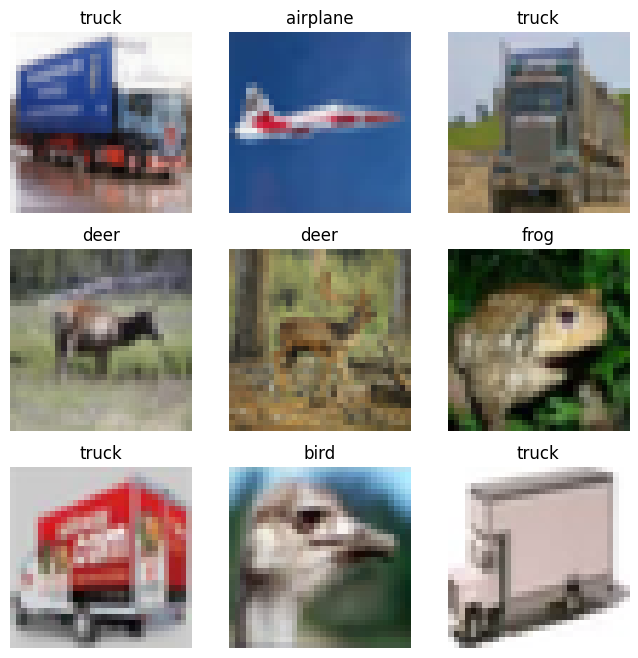

In [3]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute([1,2,0])) #[C,H,W] => [H,W,C], axis change
plt.show()

데이터셋 객체는 한 번에 하나의 데이터와 정답을 가져오지만, 학습을 위해 미니배치(minibatch)로 데이터를 가져올 필요가 있다. 또한 과적합을 줄이기 위해 매 epoch마다 데이터의 순서를 섞어(shuffle)주어야 한다.

이를 위해 파이토치는 [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)를 제공한다.

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


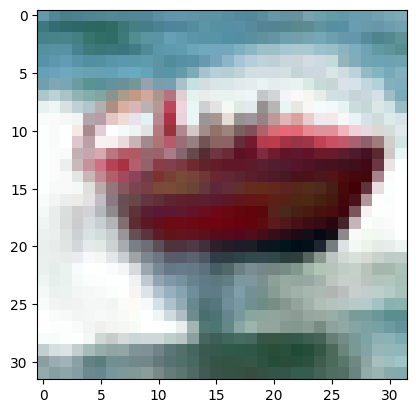

Label: ship


In [5]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute([1,2,0]), cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")

# 2. Build your Convolutional Neural Network!

- Pytorch에서 모델을 정의하기 위해 nn.Module 클래스를 상속
- \_\_init\_\_ 함수에서 네트워크의 하위 레이어들을 정의
- forward 함수에서 어떻게 데이터를 통과시킬 것인지 정의


In [6]:
from torch import nn
from torch.nn.functional import relu, max_pool2d

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
def Conv_block(inf, outf):
    return nn.Sequential(
    nn.Conv2d(in_channels=inf, out_channels=outf, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(num_features=outf, momentum=0.1),
    nn.ReLU())

In [9]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv_block1 = Conv_block(3, 32)
        self.conv_block2 = Conv_block(32, 32)
        self.conv_block3 = Conv_block(32, 64)
        self.conv_block4 = Conv_block(64, 64)
        self.conv_block5 = Conv_block(64, 128)
        self.conv_block6 = Conv_block(128, 128)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.maxpool(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.maxpool(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
model = ImageClassifier().to(device)
print(model)

ImageClassifier(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, e

In [11]:
X = torch.rand(1, 3, 32, 32, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([9], device='cuda:0')


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train() #모델을 학습모드로,
    total_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #샘플과 정답을 GPU로 전달
        pred = model(X)
        loss = loss_fn(pred, y) # Compute prediction error
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad() #optimizer의 gradient 초기화
        loss.backward() #loss
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss /= num_batches
    correct /= size
    return total_loss, correct

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #모델을 평가모드로,
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size
    return total_loss, correct

In [ ]:
epochs = 40

train_losses = []
val_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    print(f"Train Error: \n Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    val_loss, val_acc = test(val_dataloader, model, loss_fn)
    print(f"Validation Error: \n Accuracy: {(100*val_acc):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298981  [    0/50000]
loss: 1.666327  [ 6400/50000]
loss: 1.443391  [12800/50000]
loss: 1.542538  [19200/50000]
loss: 1.103361  [25600/50000]
loss: 0.898681  [32000/50000]
loss: 1.025917  [38400/50000]
loss: 1.061899  [44800/50000]
Train Error: 
 Accuracy: 56.5%, Avg loss: 1.203807 

Validation Error: 
 Accuracy: 67.7%, Avg loss: 0.946127 

Epoch 2
-------------------------------
loss: 0.701671  [    0/50000]
loss: 0.791264  [ 6400/50000]
loss: 0.787636  [12800/50000]
loss: 0.844218  [19200/50000]
loss: 0.552119  [25600/50000]
loss: 0.693819  [32000/50000]
loss: 0.514439  [38400/50000]
loss: 0.515122  [44800/50000]
Train Error: 
 Accuracy: 73.4%, Avg loss: 0.752796 

Validation Error: 
 Accuracy: 72.1%, Avg loss: 0.804766 

Epoch 3
-------------------------------
loss: 0.486308  [    0/50000]
loss: 0.390556  [ 6400/50000]
loss: 0.799391  [12800/50000]
loss: 0.521697  [19200/50000]
loss: 0.589022  [25600/50000]
loss: 0.702641  [32000/50000

In [ ]:
plt.figure(figsize=(14,4))
plt.xlabel("Epochs")
plt.xticks(range(1,len(train_losses)+1))
plt.ylabel("losses")
plt.plot(list(range(1,len(train_losses)+1)), train_losses, label='train loss')
plt.plot(list(range(1,len(val_losses)+1)), val_losses, label='val loss')
plt.legend()
plt.show()

# 3.Train your model smarter

모델 학습 시 조금 더 똑똑하게 학습하기 위한 유용한 도구들이 존재합니다.

- EarlyStopping : validation loss가 일정 이상 줄어들지 않으면, 학습을 정지합니다.
- Learning rate scheduling : 학습 중 조건에 따라 학습률을 조정합니다.
- TensorBoard : [TensorBoard](https://www.tensorflow.org/tensorboard)에서 읽을 수 있는 형태로 학습 로그를 저장합니다.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
loss_fn = nn.CrossEntropyLoss()

학습률 스케쥴러 중 하나인 CosineAnnealingWarmRestarts를 사용하면, batch를 학습함에 따라 다음과 같이 학습률이 변화된다.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1000, T_mult=1, eta_min=0.0)

lrs = []
opt_lrs = []
for i in range(10000):
    scheduler.step()
    opt_lrs.append(optimizer.param_groups[0]["lr"])
plt.xlabel("iteration(batch)")
plt.ylabel("learning rate")
plt.plot(list(range(10000)), opt_lrs)

## 학습에 스케쥴러 사용

In [ ]:
model = ImageClassifier().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1000, T_mult=1, eta_min=0.0)

## 학습에 얼리스타핑 사용

In [ ]:
import numpy as np

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train() #모델을 학습모드로,
    total_loss, correct, lrs = 0, 0, []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #샘플과 정답을 GPU로 전달
        pred = model(X)
        loss = loss_fn(pred, y) # Compute prediction error
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad() #optimizer의 gradient 초기화
        loss.backward() #loss
        optimizer.step() #update the parameters
        lrs.append(optimizer.param_groups[0]['lr']) #append the current learning rate
        scheduler.step() #update the learning rate

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss /= num_batches
    correct /= size
    return total_loss, correct, lrs


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #모델을 평가모드로,
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size
    return total_loss, correct

In [ ]:
from torch.utils.tensorboard import SummaryWriter

epochs = 200
writer = SummaryWriter(comment="pytorch-experiment#1") #tensorboard에 학습로그 기록
ckpt_path = os.path.dirname(writer.get_logdir())
early_stopping = EarlyStopping(patience = 10, verbose = True, path=os.path.join(ckpt_path ,'MyCNN.pt'))

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc, lrs = train(train_dataloader, model, loss_fn,
                                       optimizer, scheduler)
    print(f"Train Error: \n Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    val_loss, val_acc = test(val_dataloader, model, loss_fn)
    print(f"Validation Error: \n Accuracy: {(100*val_acc):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    writer.add_scalar('Loss/train', train_loss, t)
    writer.add_scalar('Loss/val', val_loss, t)
    writer.add_scalar('Accuracy/train', train_acc, t)
    writer.add_scalar('Accuracy/val', val_acc, t)
    for _iter, lr in enumerate(lrs):
        writer.add_scalar('learning_rate', lr, t*len(train_dataloader)+_iter+1)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


print("Done!")

모델 세이브&로드

In [ ]:
new_model = ImageClassifier().to(device)
new_model.load_state_dict(torch.load('MyCNN.pt'))
new_model.eval()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/